In [43]:
import os
import cv2
from src.utils.histograms import change_color_space, plot_histograms, get_histograms
# Directory containing the images
image_dir = 'data/qsd2_w1'

# List to store the images
images = []
color_space='LAB'
# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = change_color_space(img, color_space)
            images.append(img)

In [9]:
def extract_top_left_pixel_values(image):
    """
    Extracts the values of the top left pixel in each channel of the given image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    tuple: A tuple containing the values of the top left pixel in each channel.
    """
    if image is None or image.size == 0:
        raise ValueError("Invalid image provided")
    
    # Extract the values of the top left pixel
    top_left_pixel_values = image[0, 0]
    
    return tuple(top_left_pixel_values)

In [10]:
import matplotlib.pyplot as plt

def show_image_at_index(images, index):
    """
    Displays the image at the given index from the list of images.

    Parameters:
    images (list): List of images.
    index (int): Index of the image to display.

    Raises:
    IndexError: If the index is out of range.
    """
    if index < 0 or index >= len(images):
        raise IndexError("Index out of range")
    
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_LAB2RGB))
    plt.title(f"Image at index {index}")
    plt.axis('off')
    plt.show()

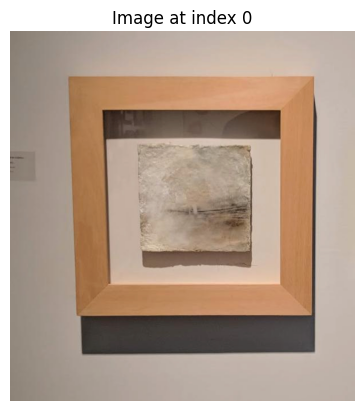

In [12]:
show_image_at_index(images, 0)

In [13]:
def show_image_channels(image, color_space):
    """
    Displays the decomposition of an image in its 3 channels.

    Parameters:
    image (numpy.ndarray): The input image.
    color_space (str): The color space of the image (e.g., 'RGB', 'LAB', etc.).

    Raises:
    ValueError: If the image does not have 3 channels.
    """
    if image.shape[2] != 3:
        raise ValueError("The image does not have 3 channels")

    # Create a figure with 4 subplots (1 for the original image and 3 for the channels)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Display the original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_LAB2RGB) if color_space == 'LAB' else image)
    axes[0].set_title(f"Original Image ({color_space})")
    axes[0].axis('off')
    
    # Display each channel
    for i in range(3):
        channel_img = image[:, :, i]
        axes[i + 1].imshow(channel_img, cmap='gray')
        axes[i + 1].set_title(f"Channel {i + 1}")
        axes[i + 1].axis('off')
    
    plt.show()

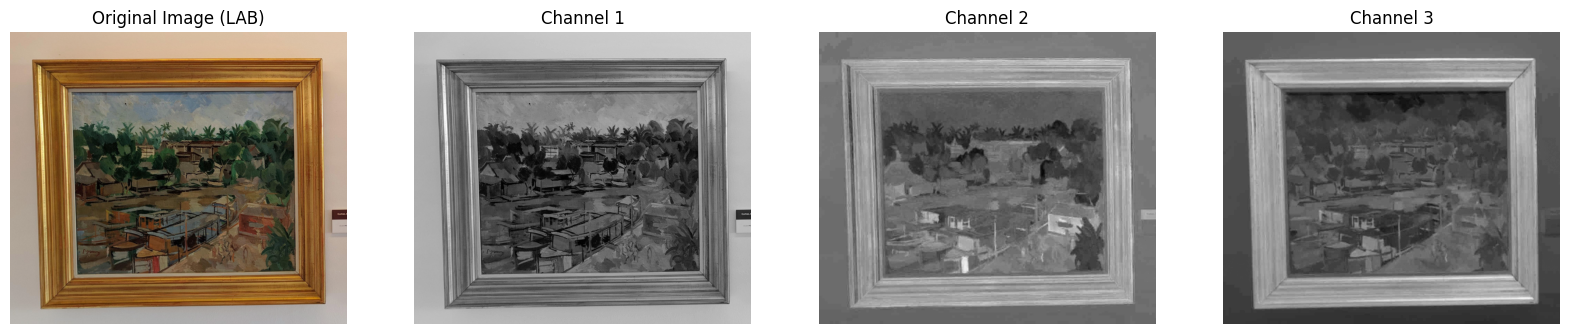

In [20]:
# Example usage
show_image_channels(images[10], color_space='LAB')

In [40]:
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

def read_border_pixels(image, border_width=10):
    """
    Reads the pixel values of the borders of an image.

    Parameters:
    image (numpy.ndarray): The input image in CIELAB format.
    border_width (int): The width of the border to read.

    Returns:
    numpy.ndarray: The pixel values of the borders.
    """
    if image.shape[2] != 3:
        raise ValueError("The image does not have 3 channels")

    # Extract border pixels
    top_border = image[:border_width, :, 1].flatten()
    top_border_2 = image[:border_width, :, 2].flatten()
    bottom_border = image[-border_width:, :, 1].flatten()
    bottom_border_2 = image[:border_width, :, 2].flatten()
    left_border = image[:, :border_width, 1].flatten()
    left_border_2 = image[:border_width, :, 2].flatten()
    right_border = image[:, -border_width:, 1].flatten()
    right_border_2 = image[:border_width, :, 2].flatten()

    # Combine all border pixels
    border_pixels = np.concatenate((top_border, bottom_border, left_border, right_border))
    border_pixels_2 = np.concatenate((top_border_2, bottom_border_2, left_border_2, right_border_2))
    
    return border_pixels, border_pixels_2

def compute_histograms(border_pixels, border_pixels2):
    """
    Computes the histograms for the given border pixels.

    Parameters:
    border_pixels (numpy.ndarray): The pixel values of the borders.

    Returns:
    tuple: Histograms for each channel.
    """
    hist_channel_1, bins_1 = np.histogram(border_pixels, bins=256, range=(0, 255))
    hist_channel_2, bins_2 = np.histogram(border_pixels2, bins=256, range=(0, 255))
    return hist_channel_1, hist_channel_2, bins_1, bins_2

def plot_histogram_with_mean_std(values):
    # Convert input to a numpy array for easier computation
    data = np.array(values)
    
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add vertical lines for mean and std deviations
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='--', label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='green', linestyle='--', label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    
    # Add labels and title
    plt.title('Histogram with Mean and Standard Deviation')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()

def create_2d_gaussian(hist_channel_1, hist_channel_2):
    """
    Creates a 2D Gaussian from the given histograms.

    Parameters:
    hist_channel_1 (numpy.ndarray): Histogram for the first channel.
    hist_channel_2 (numpy.ndarray): Histogram for the second channel.

    Returns:
    numpy.ndarray: The 2D Gaussian array.
    """
    mean = [np.mean(hist_channel_1), np.mean(hist_channel_2)]
    cov = np.cov(hist_channel_1, hist_channel_2)
    x, y = np.meshgrid(np.linspace(0, 255, 256), np.linspace(0, 255, 256))
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    return rv.pdf(pos)

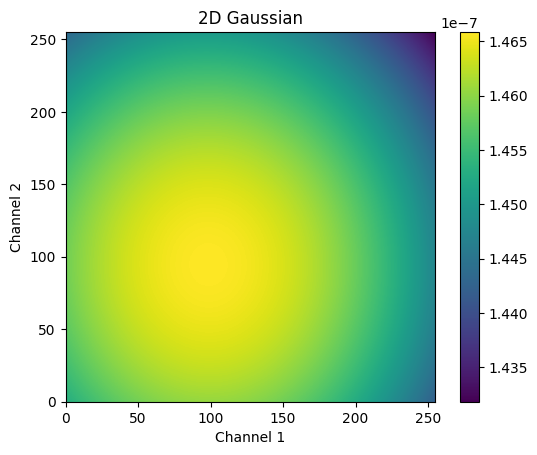

In [45]:
img = images[0]

# Example usage
border_pixels, border_pixels_2 = read_border_pixels(img)
hist_channel_1, hist_channel_2, bins_1, bins_2 = compute_histograms(border_pixels, border_pixels_2)
gaussian_2d = create_2d_gaussian(hist_channel_1, hist_channel_2)

plt.imshow(gaussian_2d, extent=(0, 255, 0, 255), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian')
plt.xlabel('Channel 1')
plt.ylabel('Channel 2')
plt.show()

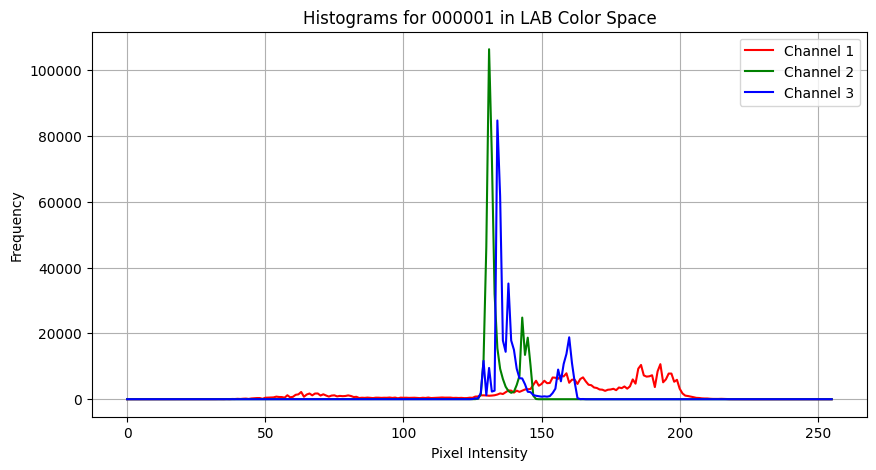

In [44]:
plot_histograms(get_histograms(images[0],'LAB'),'LAB','000001')